# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore')

from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split, cross_val_predict

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import joblib

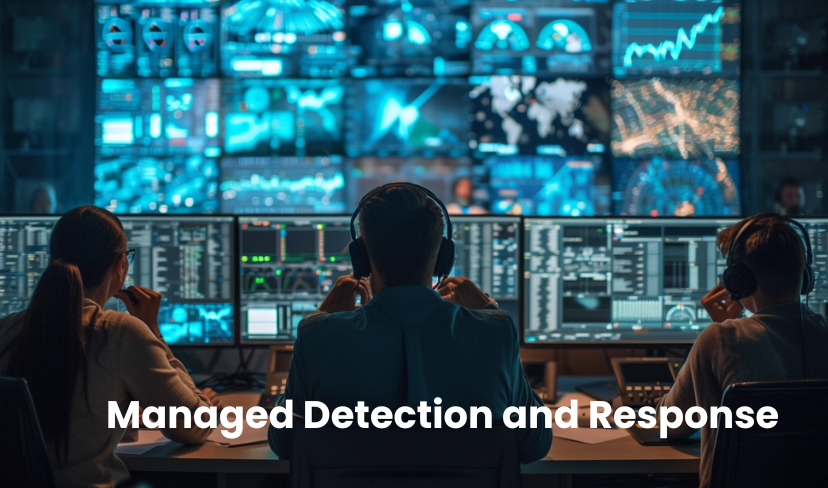

# PROBLEM STATEMENT
As digital transactions become more frequent, users are increasingly vulnerable to fraudulent or unusual activities that may go undetected until significant financial damage is done. Our transaction app currently lacks a mechanism to identify abnormal spending behaviors or unauthorized access patterns in real-time. This makes it difficult for users to detect suspicious transactions early and for the system to prevent potential fraud. To enhance user trust and platform security, we aim to implement an anomaly detection system that automatically flags unusual transactions based on historical user behavior, transaction patterns, and contextual factors such as location and time. The system will be developed in Python and integrated into the app to provide real-time alerts and insights for both users and administrators.

## DEFINITION OF ANOMALY IN WIREBUDDY
1. Fraudulent Activity (Transfers to suspicious accounts, amounts outside user's normal range)
2. Unusual Frequency (Many small withdrawals within minutes)
3. Behavioral Deviations (User normally sends GHS 200/day, suddenly sends GHS 5,000 at 3AM)
4. Location Anomalies (Transactions from unusual IP or Geolocation)

# Dataset Loading

In [2]:
ml = pd.read_csv("fraud.csv")

# Dataset Overview

In [3]:
print("DATASET SHAPE")
print(f" {ml.shape[0]} rows")
print(f" {ml.shape[1]} columns")

DATASET SHAPE
 50000 rows
 21 columns


In [4]:
# Check first 5 rows
ml.head()

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Timestamp,Account_Balance,Device_Type,Location,Merchant_Category,IP_Address_Flag,...,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Type,Card_Age,Transaction_Distance,Authentication_Method,Risk_Score,Is_Weekend,Fraud_Label
0,TXN_33553,USER_1834,39.79,POS,2023-08-14 19:30:00,93213.17,Laptop,Sydney,Travel,0,...,7,437.63,3,Amex,65,883.17,Biometric,0.8494,0,0
1,TXN_9427,USER_7875,1.19,Bank Transfer,2023-06-07 04:01:00,75725.25,Mobile,New York,Clothing,0,...,13,478.76,4,Mastercard,186,2203.36,Password,0.0959,0,1
2,TXN_199,USER_2734,28.96,Online,2023-06-20 15:25:00,1588.96,Tablet,Mumbai,Restaurants,0,...,14,50.01,4,Visa,226,1909.29,Biometric,0.8400,0,1
3,TXN_12447,USER_2617,254.32,ATM Withdrawal,2023-12-07 00:31:00,76807.20,Tablet,New York,Clothing,0,...,8,182.48,4,Visa,76,1311.86,OTP,0.7935,0,1
4,TXN_39489,USER_2014,31.28,POS,2023-11-11 23:44:00,92354.66,Mobile,Mumbai,Electronics,0,...,14,328.69,4,Mastercard,140,966.98,Password,0.3819,1,1


In [5]:
# Check empty values
ml.isnull().sum()

Transaction_ID                  0
User_ID                         0
Transaction_Amount              0
Transaction_Type                0
Timestamp                       0
Account_Balance                 0
Device_Type                     0
Location                        0
Merchant_Category               0
IP_Address_Flag                 0
Previous_Fraudulent_Activity    0
Daily_Transaction_Count         0
Avg_Transaction_Amount_7d       0
Failed_Transaction_Count_7d     0
Card_Type                       0
Card_Age                        0
Transaction_Distance            0
Authentication_Method           0
Risk_Score                      0
Is_Weekend                      0
Fraud_Label                     0
dtype: int64

In [6]:
# Statistical summary of the data
ml.describe().T

,count,mean,std,min,25%,50%,75%,max
Transaction_Amount,50000.0,99.411012,98.687292,0.0000,28.6775,69.66000,138.852500,1174.14
Account_Balance,50000.0,50294.065981,28760.458557,500.4800,25355.9950,50384.43000,75115.135000,99998.31
IP_Address_Flag,50000.0,0.050200,0.218360,0.0000,0.0000,0.00000,0.000000,1.00
Previous_Fraudulent_Activity,50000.0,0.098400,0.297858,0.0000,0.0000,0.00000,0.000000,1.00
Daily_Transaction_Count,50000.0,7.485240,4.039637,1.0000,4.0000,7.00000,11.000000,14.00
Avg_Transaction_Amount_7d,50000.0,255.271924,141.382279,10.0000,132.0875,256.08500,378.032500,500.00
Failed_Transaction_Count_7d,50000.0,2.003540,1.414273,0.0000,1.0000,2.00000,3.000000,4.00
Card_Age,50000.0,119.999940,68.985817,1.0000,60.0000,120.00000,180.000000,239.00
Transaction_Distance,50000.0,2499.164155,1442.013834,0.2500,1256.4975,2490.78500,3746.395000,4999.93
Risk_Score,50000.0,0.501556,0.287774,0.0001,0.2540,0.50225,0.749525,1.00


In [7]:
ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Transaction_ID                50000 non-null  object 
 1   User_ID                       50000 non-null  object 
 2   Transaction_Amount            50000 non-null  float64
 3   Transaction_Type              50000 non-null  object 
 4   Timestamp                     50000 non-null  object 
 5   Account_Balance               50000 non-null  float64
 6   Device_Type                   50000 non-null  object 
 7   Location                      50000 non-null  object 
 8   Merchant_Category             50000 non-null  object 
 9   IP_Address_Flag               50000 non-null  int64  
 10  Previous_Fraudulent_Activity  50000 non-null  int64  
 11  Daily_Transaction_Count       50000 non-null  int64  
 12  Avg_Transaction_Amount_7d     50000 non-null  float64
 13  F

# Converting datatype for Timestamp column to datetime

In [8]:
ml['Timestamp'] = pd.to_datetime(ml['Timestamp'])

# Creating Date & Time column from Timestamp


In [9]:
ml['Date'] = ml['Timestamp'].dt.date
ml['Time'] = ml['Timestamp'].dt.time

In [31]:
# GROUPING FEATURES INTO NUMERICAL, BINARY AND CATEGORICAL

# Numerical Features

In [10]:
num_cols=ml.select_dtypes(include='number').columns.tolist()
num_cols

['Transaction_Amount',
 'Account_Balance',
 'IP_Address_Flag',
 'Previous_Fraudulent_Activity',
 'Daily_Transaction_Count',
 'Avg_Transaction_Amount_7d',
 'Failed_Transaction_Count_7d',
 'Card_Age',
 'Transaction_Distance',
 'Risk_Score',
 'Is_Weekend',
 'Fraud_Label']

# Removed this column because it was unintentionally causing data leakage.

In [11]:
num_cols.remove('Failed_Transaction_Count_7d')

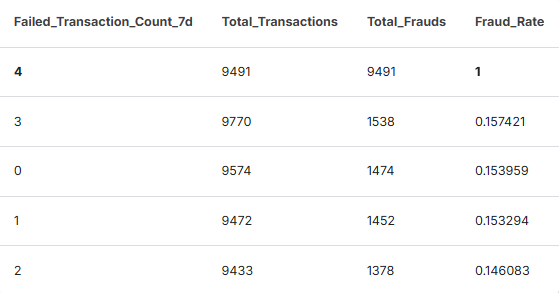

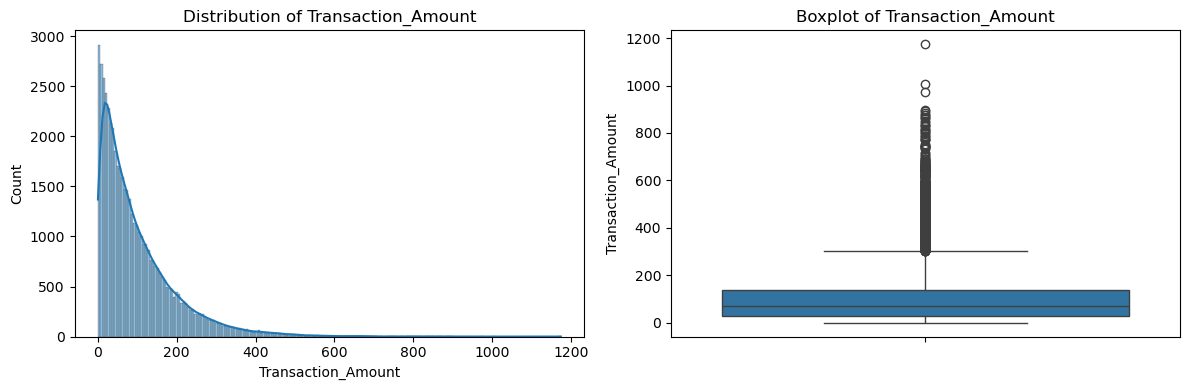

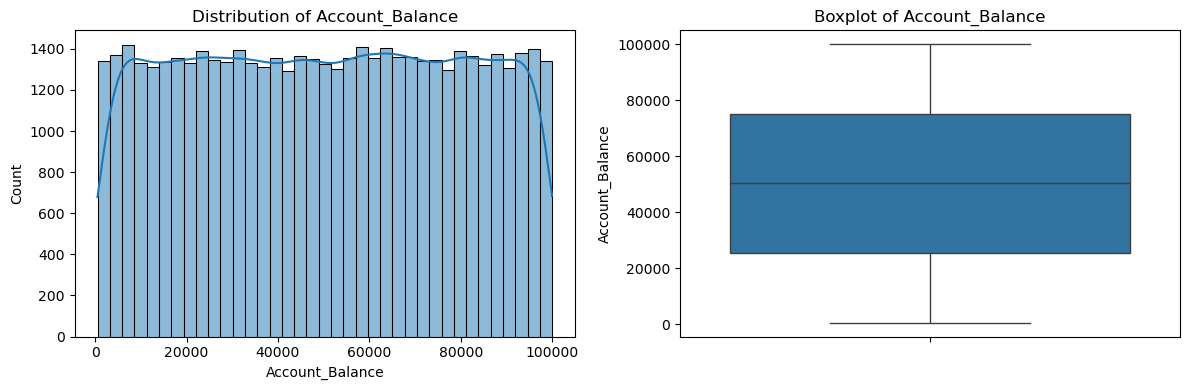

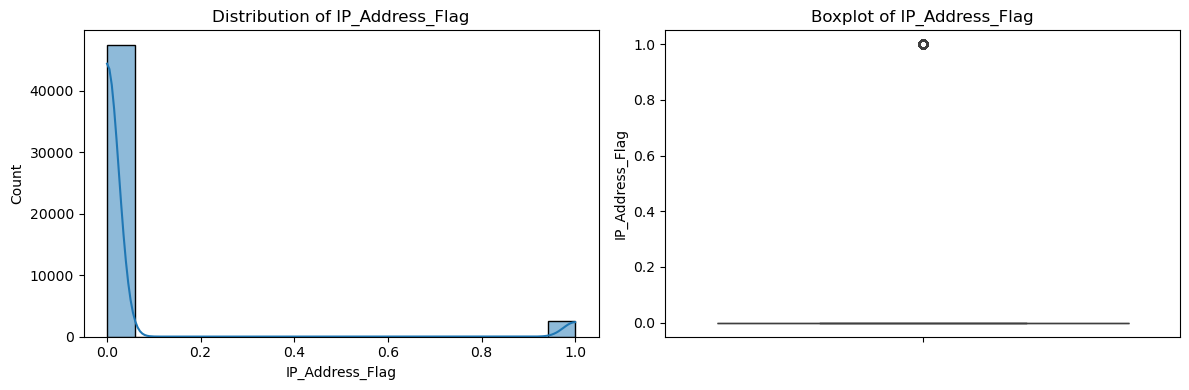

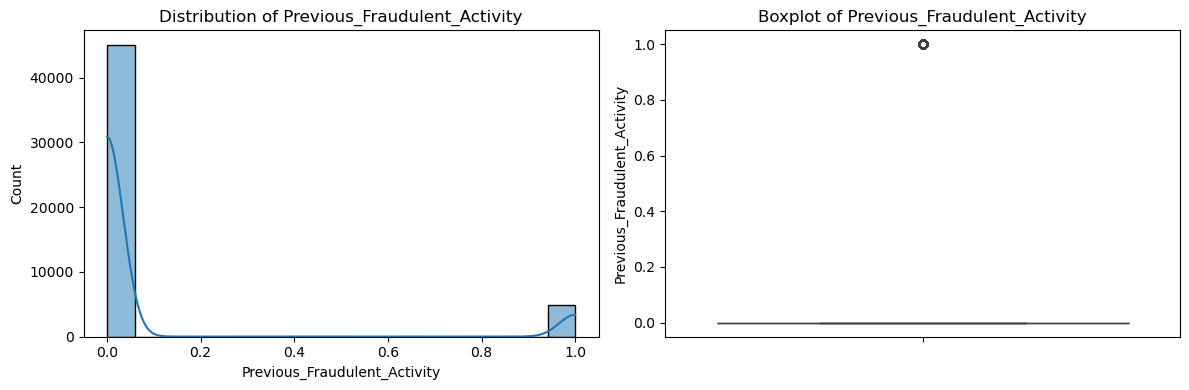

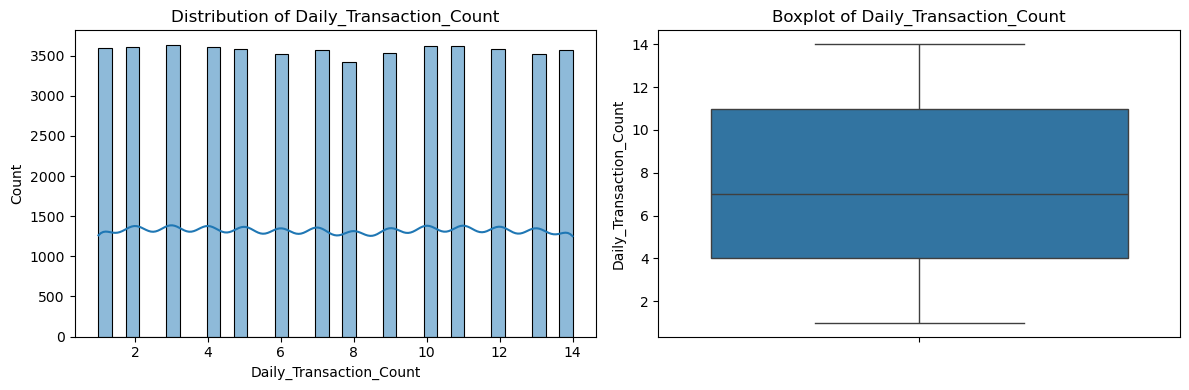

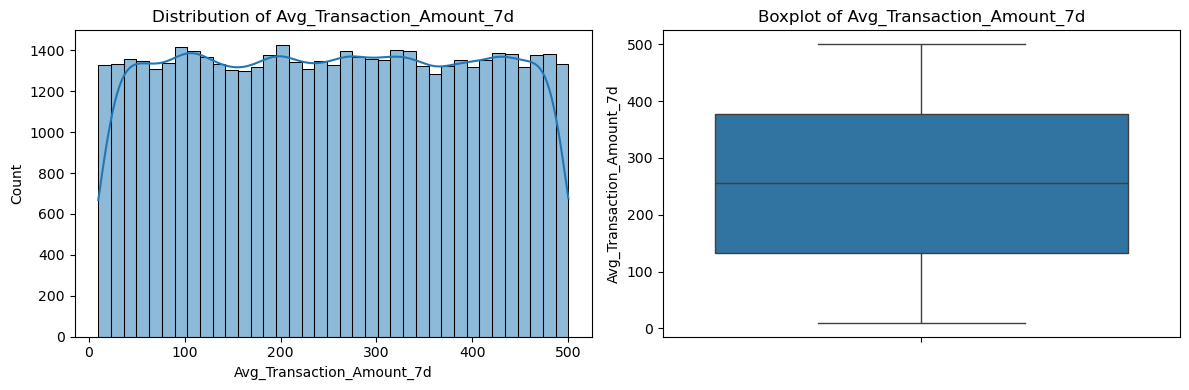

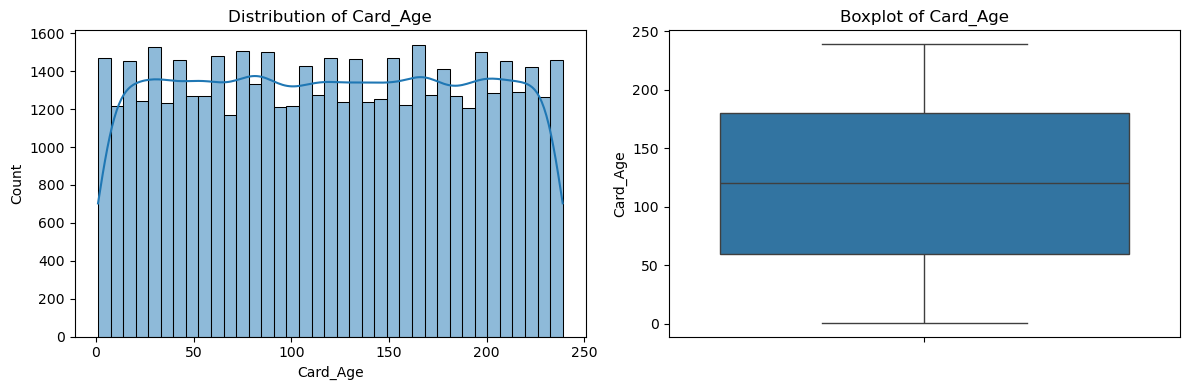

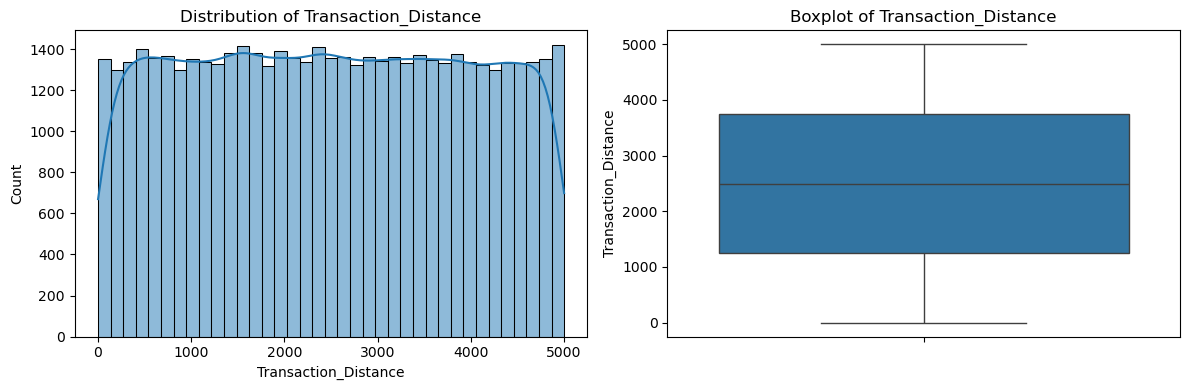

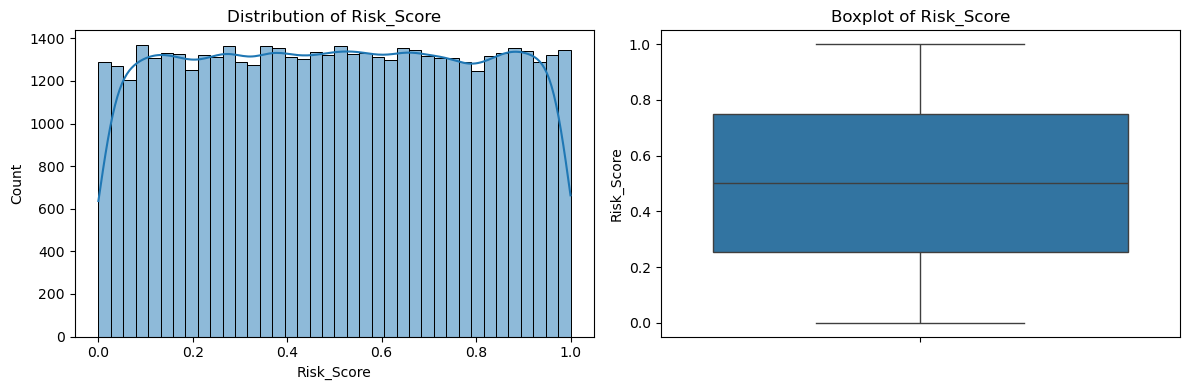

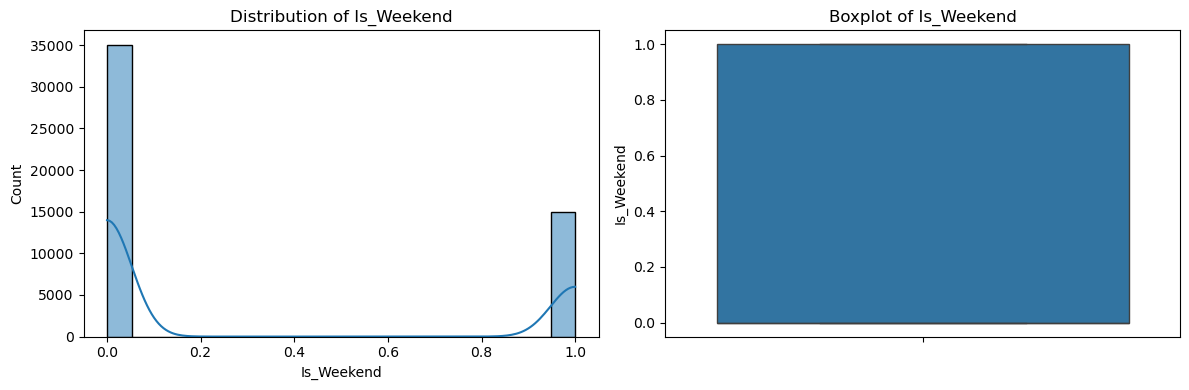

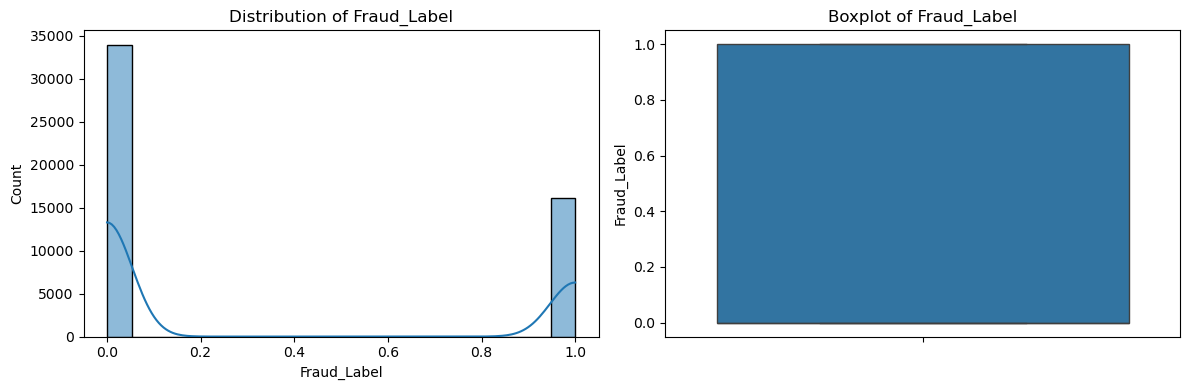

In [12]:
for col in num_cols:
    fig, axes = plt.subplots(1,2,figsize=(12,4))
    axes[0].set_title(f"Distribution of {col}")
    axes[1].set_title(f"Boxplot of {col}")
    sns.histplot(ml[col], kde=True, ax=axes[0])
    sns.boxplot(ml[col], ax=axes[1])
    plt.tight_layout()
    plt.show()

In [13]:
binary_cols=['Is_Weekend', 'Previous_Fraudulent_Activity', 'IP_Address_Flag', 'Fraud_Label']
num_cols=[x for x in num_cols if x not in binary_cols]
num_cols

['Transaction_Amount',
 'Account_Balance',
 'Daily_Transaction_Count',
 'Avg_Transaction_Amount_7d',
 'Card_Age',
 'Transaction_Distance',
 'Risk_Score']

# Binary Features

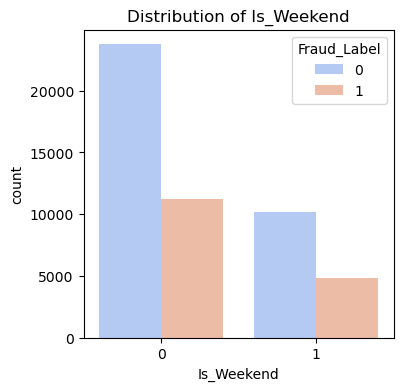

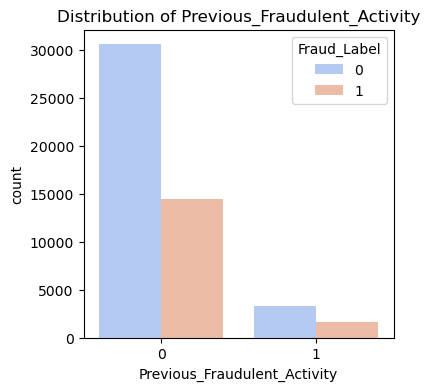

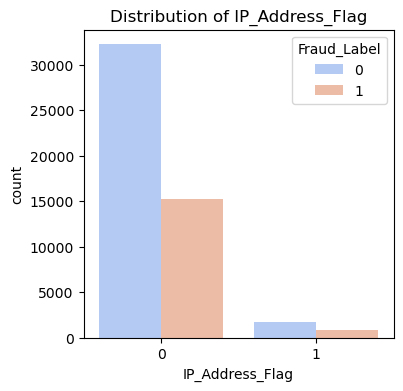

In [14]:
for col in binary_cols[:-1]:
    plt.figure(figsize=(4,4))
    plt.title(f"Distribution of {col}")
    sns.countplot(x=col, data=ml, hue=ml['Fraud_Label'], palette='coolwarm')
    plt.show()

In [15]:
for col in binary_cols:
    print("*"*50)
    print(ml[col].value_counts())

**************************************************
Is_Weekend
0    35018
1    14982
Name: count, dtype: int64
**************************************************
Previous_Fraudulent_Activity
0    45080
1     4920
Name: count, dtype: int64
**************************************************
IP_Address_Flag
0    47490
1     2510
Name: count, dtype: int64
**************************************************
Fraud_Label
0    33933
1    16067
Name: count, dtype: int64


# Category Features

In [16]:
cat_cols=[x for x in ml.columns if x not in num_cols and x not in binary_cols]
cat_cols

['Transaction_ID',
 'User_ID',
 'Transaction_Type',
 'Timestamp',
 'Device_Type',
 'Location',
 'Merchant_Category',
 'Failed_Transaction_Count_7d',
 'Card_Type',
 'Authentication_Method',
 'Date',
 'Time']

In [17]:
#We removed Transaction_ID, User_ID because they are unique and dont include any useful information
#Also we removed timestamp from this list, it is not category column in this form, but we will handle it

cat_cols.remove('Transaction_ID')
cat_cols.remove('User_ID')
cat_cols.remove('Timestamp')
cat_cols

['Transaction_Type',
 'Device_Type',
 'Location',
 'Merchant_Category',
 'Failed_Transaction_Count_7d',
 'Card_Type',
 'Authentication_Method',
 'Date',
 'Time']

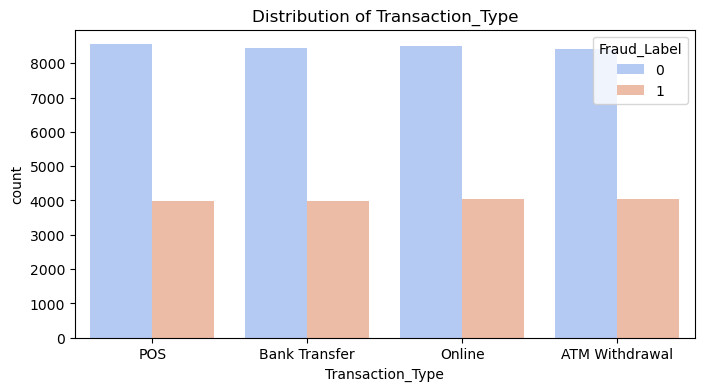

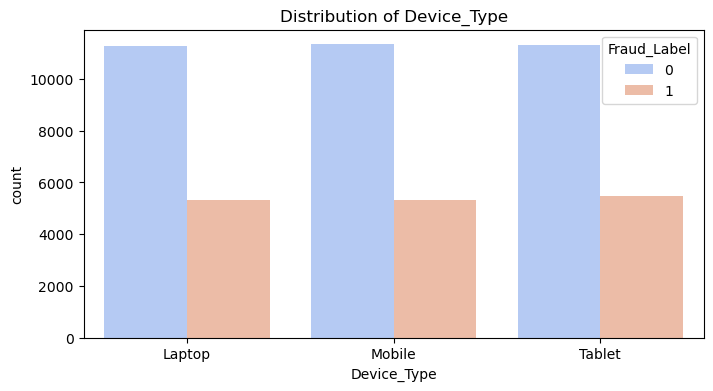

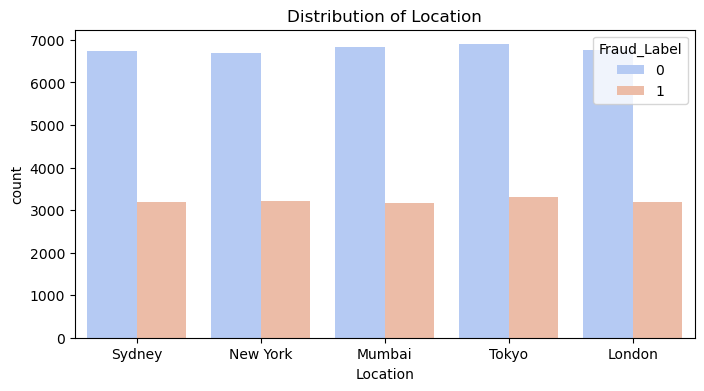

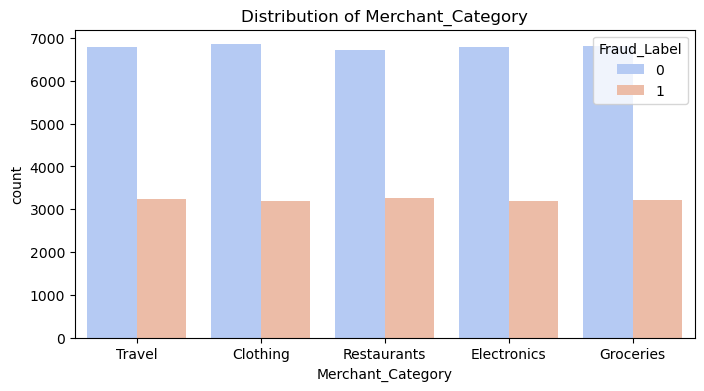

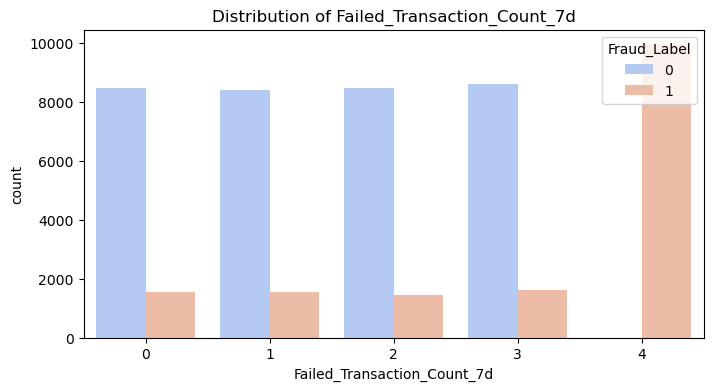

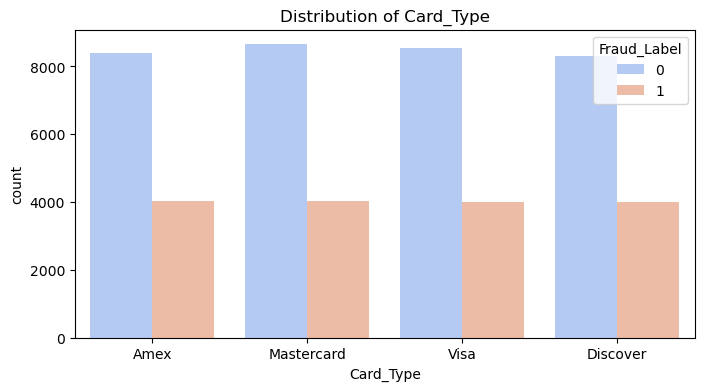

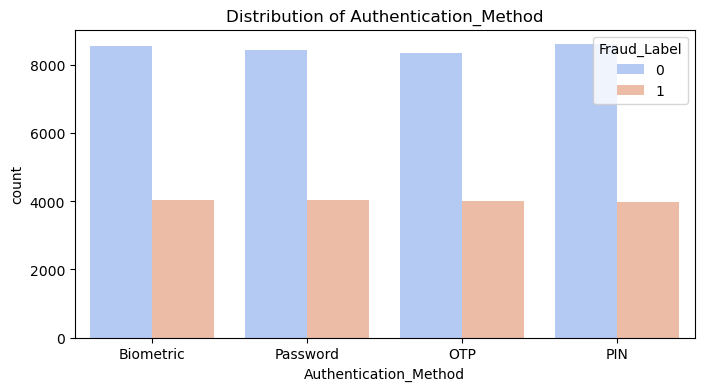

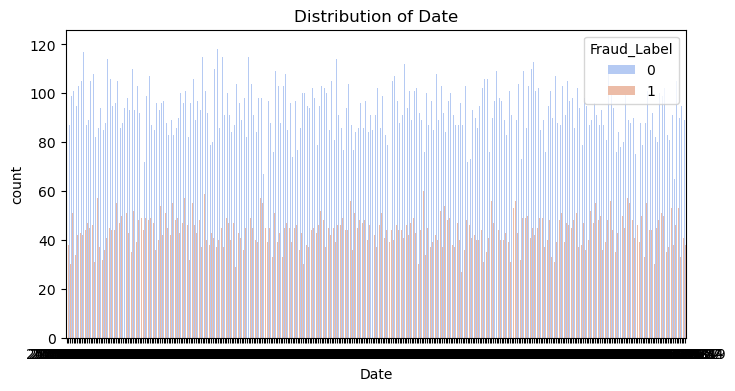

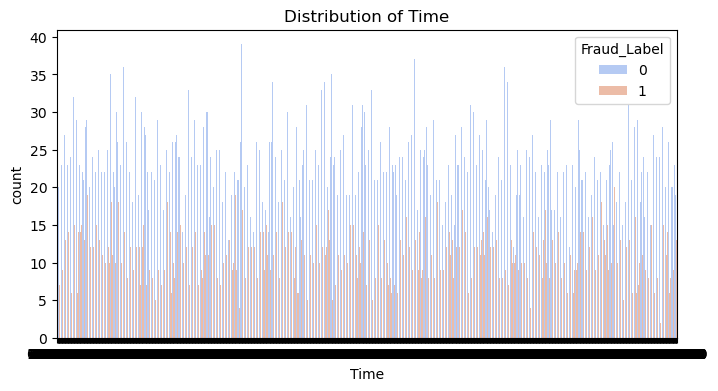

In [18]:
for col in cat_cols:
    plt.figure(figsize=(8,4))
    plt.title(f"Distribution of {col}")
    sns.countplot(x=col, data=ml, hue=ml['Fraud_Label'], palette='coolwarm')
    plt.show()

In [19]:
for col in cat_cols:
    print("*"*50)
    print(ml[col].value_counts())

**************************************************
Transaction_Type
POS               12549
Online            12546
ATM Withdrawal    12453
Bank Transfer     12452
Name: count, dtype: int64
**************************************************
Device_Type
Tablet    16779
Mobile    16640
Laptop    16581
Name: count, dtype: int64
**************************************************
Location
Tokyo       10208
Mumbai       9994
London       9945
Sydney       9938
New York     9915
Name: count, dtype: int64
**************************************************
Merchant_Category
Clothing       10033
Groceries      10019
Travel         10015
Restaurants     9976
Electronics     9957
Name: count, dtype: int64
**************************************************
Failed_Transaction_Count_7d
3    10216
0    10014
4     9954
1     9919
2     9897
Name: count, dtype: int64
**************************************************
Card_Type
Mastercard    12693
Visa          12560
Amex          12419
Discover      12

# Timestamp Feature

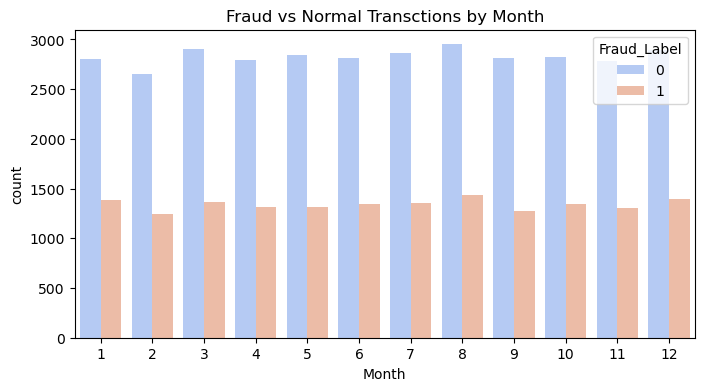

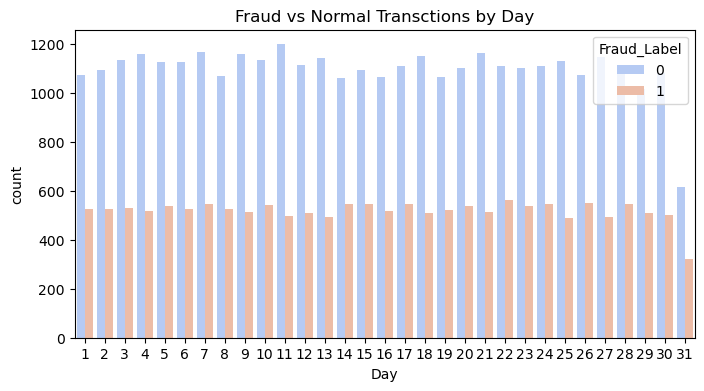

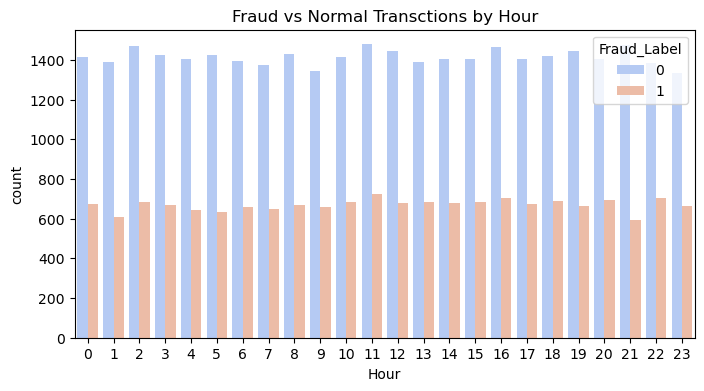

In [20]:
ml['Timestamp_dt'] = pd.to_datetime(ml['Timestamp'])
ml['Month']=ml['Timestamp_dt'].dt.month
ml['Day']=ml['Timestamp_dt'].dt.day
ml['Hour']=ml['Timestamp_dt'].dt.hour
date_cols=['Month','Day','Hour']
for col in date_cols:
    plt.figure(figsize=(8,4))
    plt.title(f"Fraud vs Normal Transctions by {col}")
    sns.countplot(x=col, data=ml, hue=ml['Fraud_Label'], palette='coolwarm')
    plt.show()
    

# Correlations Between Features

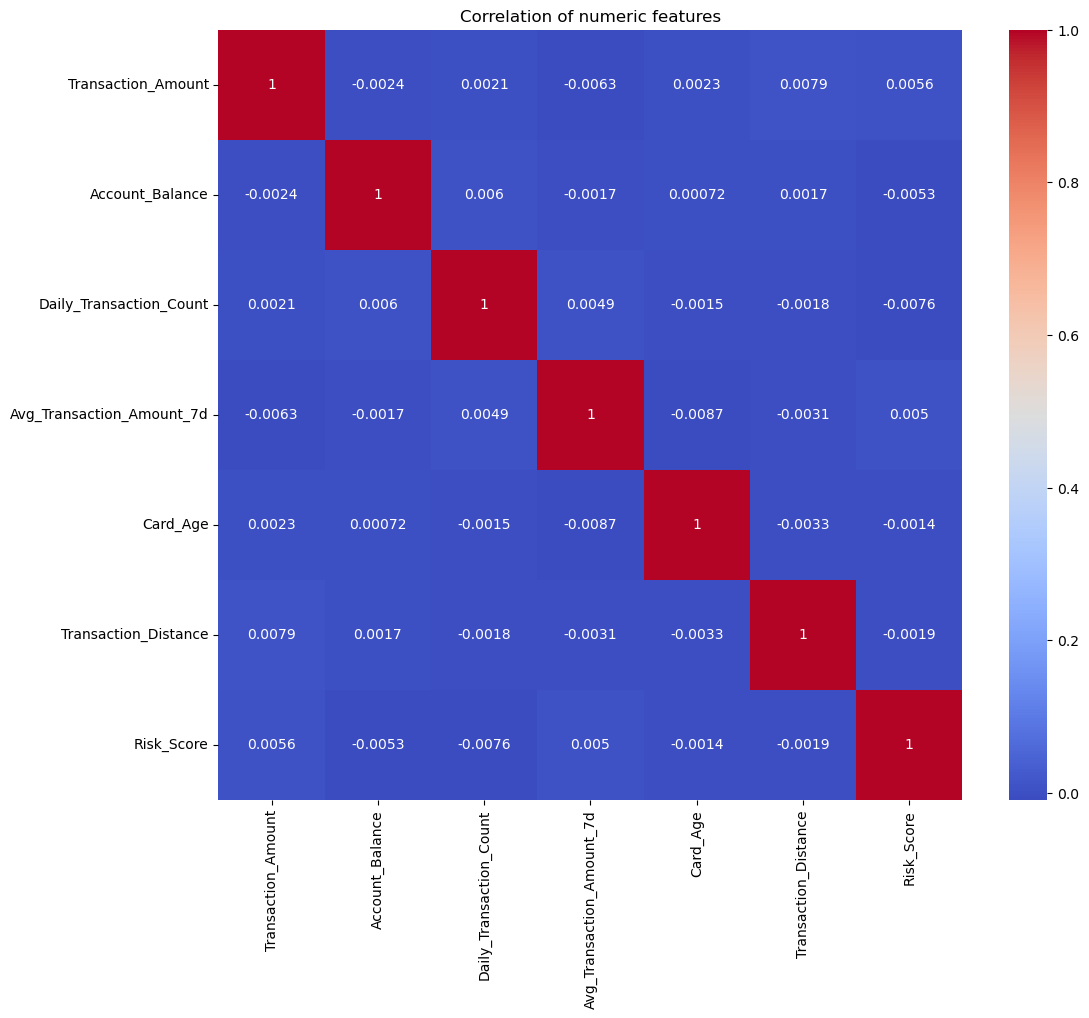

In [21]:
corr_matrix=ml[num_cols].corr()
plt.figure(figsize=(12,10))
plt.title('Correlation of numeric features')
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.show()

# Preprocessing

In [22]:
target=ml['Fraud_Label']

num_cols=['Transaction_Amount', 'Account_Balance',
          'Daily_Transaction_Count', 'Avg_Transaction_Amount_7d',
          'Transaction_Distance',
          'Month','Day', 'Hour']

to_remove=['Transaction_ID', 'User_ID','Timestamp', 'Fraud_Label']#Fraud_Label, because it's target
ml.drop(to_remove, axis=1, inplace=True)

In [23]:
num_pipeline=make_pipeline(FunctionTransformer(np.log1p), StandardScaler())
cat_pipeline=make_pipeline(OneHotEncoder(handle_unknown='ignore'))

preprocessing=ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])
preprocessing.fit(ml)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(func=<ufunc 'log1p'>)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Transaction_Amount', 'Account_Balance',
                                  'Daily_Transaction_Count',
                                  'Avg_Transaction_Amount_7d',
                                  'Transaction_Distance', 'Month', 'Day',
                                  'Hour']),
                                ('cat',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Transaction_Type', 'Device_Type', 'Location',
                                  'Merchant_Category',
                                  'Failed_Transaction_Count_7d', 'Card_Type',
                                  'Authentication_Method', 'Date', 'Time'])])

# Splitting Data: Train & Test

In [24]:
X_train,X_test,y_train,y_test=train_test_split(ml, target, test_size=0.2)

# Model Selection

In [25]:
def model_evaluation(y_true,y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"Accuracy score: {acc:.4f}")
    print(f"F1 score: {f1:.4f}")
    cm=confusion_matrix(y_true,y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted 0", "Predicted 1"], 
                yticklabels=["Actual 0", "Actual 1"])
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

XGB
Accuracy score: 0.8763
F1 score: 0.7615


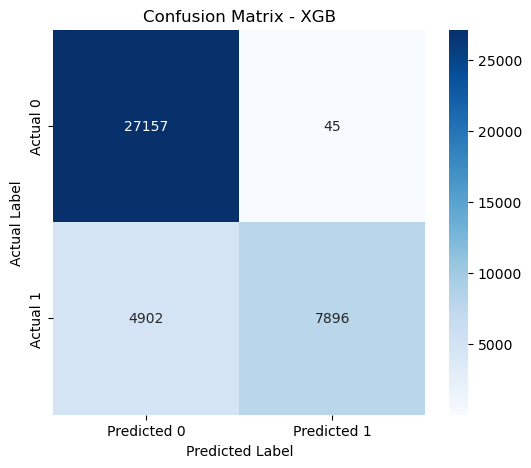

LightGBM
Accuracy score: 0.8772
F1 score: 0.7627


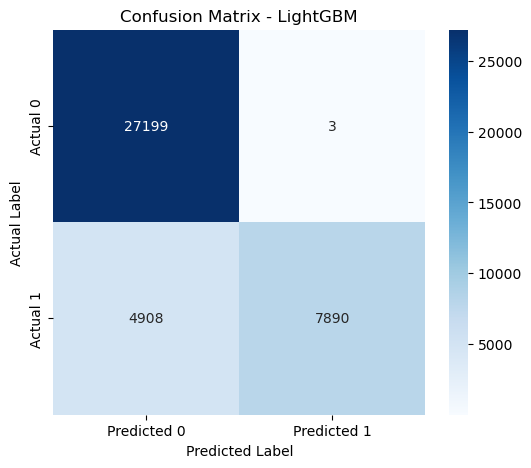

CatBoost
Accuracy score: 0.8770
F1 score: 0.7624


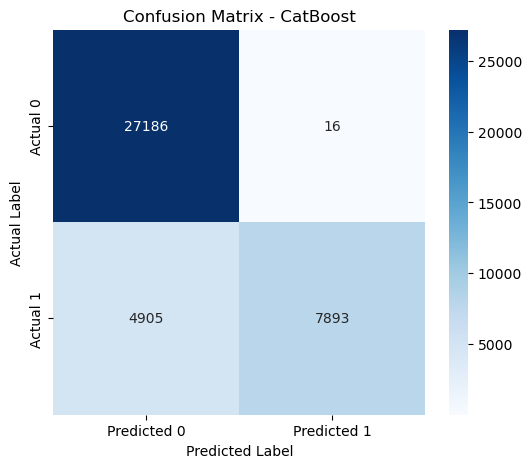

RandomForest
Accuracy score: 0.8772
F1 score: 0.7625


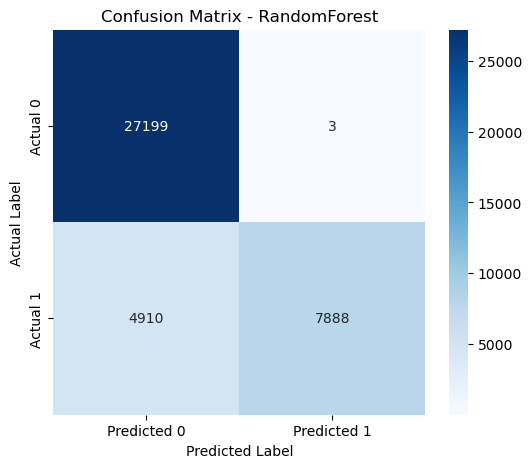

AdaBoost
Accuracy score: 0.8772
F1 score: 0.7626


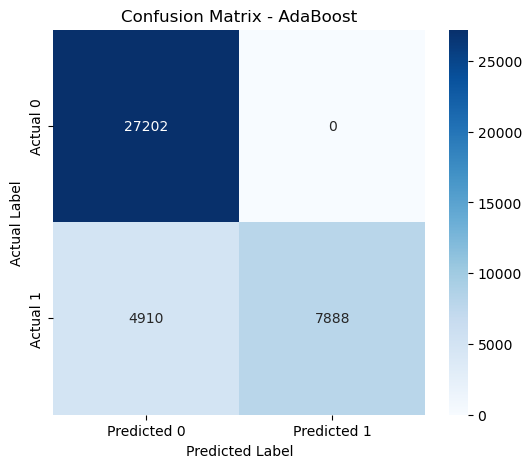

GradientBoosting
Accuracy score: 0.8769
F1 score: 0.7622


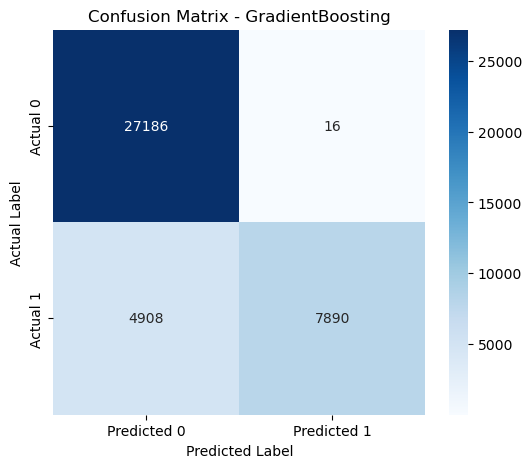

LogisticRegression
Accuracy score: 0.8767
F1 score: 0.7620


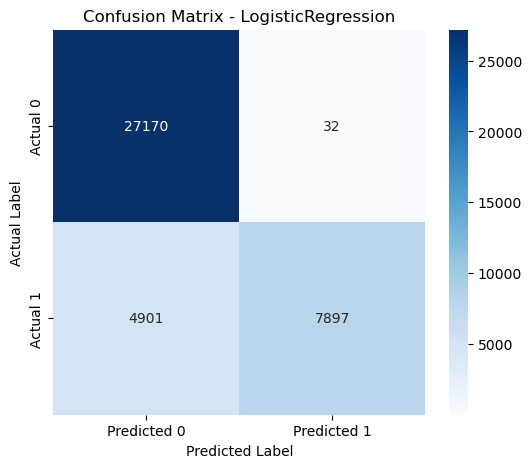

In [26]:
xgb_clf = XGBClassifier(verbosity=0)
lgbm_clf = LGBMClassifier(verbose=-1)
catboost_clf = CatBoostClassifier(verbose=0)
rf_clf = RandomForestClassifier()
adaboost_clf = AdaBoostClassifier()
gradient_clf = GradientBoostingClassifier(verbose=0)
logistic_reg = LogisticRegression()

estimators={
    'XGB':xgb_clf,
    'LightGBM': lgbm_clf,
    'CatBoost': catboost_clf,
    'RandomForest': rf_clf,
    'AdaBoost': adaboost_clf,
    'GradientBoosting': gradient_clf,
    'LogisticRegression': logistic_reg
}
models={}
for name, estimator in estimators.items():
    models[f'{name}']=make_pipeline(preprocessing, estimator)

for name, model in models.items():
    print(name)
    preds=cross_val_predict(model,X_train, y_train, cv=3)
    model_evaluation(y_train, preds, name)

# Model Testing & Results
as we can see every model achieved about 87% accuracy
so let's check it on the test set

XGB
CPU times: total: 1.52 s
Wall time: 908 ms
Accuracy score: 0.8797
F1 score: 0.7746


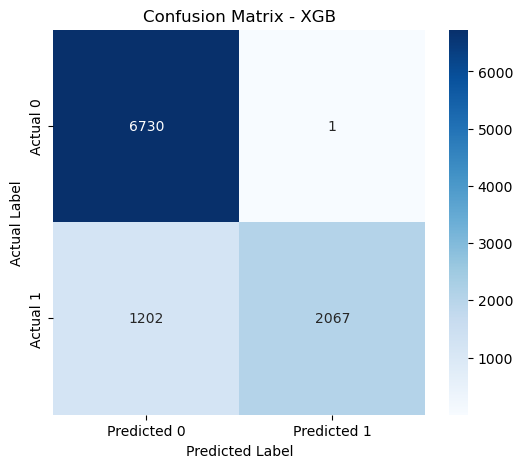

LightGBM
CPU times: total: 1.98 s
Wall time: 1.09 s
Accuracy score: 0.8797
F1 score: 0.7745


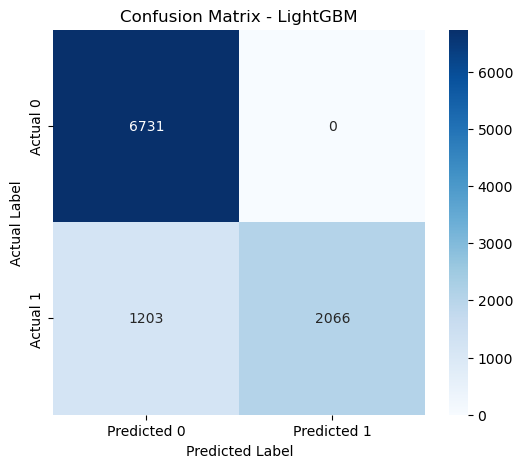

CatBoost
CPU times: total: 43.9 s
Wall time: 25 s
Accuracy score: 0.8794
F1 score: 0.7742


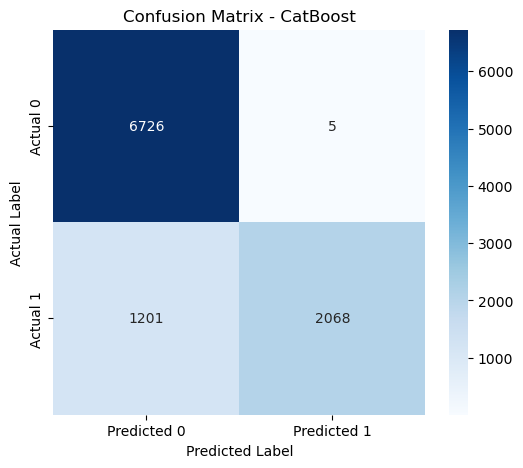

RandomForest
CPU times: total: 1min 1s
Wall time: 1min 20s
Accuracy score: 0.8796
F1 score: 0.7744


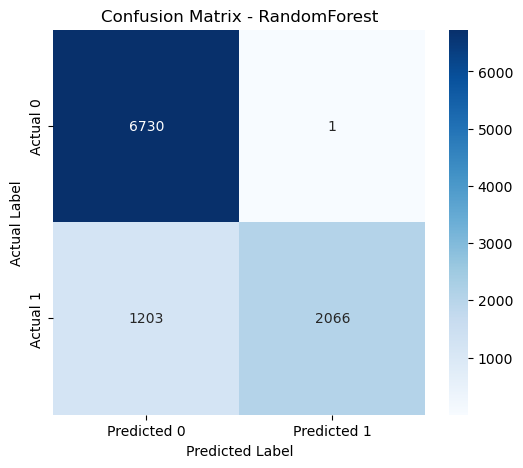

AdaBoost
CPU times: total: 4.78 s
Wall time: 5.97 s
Accuracy score: 0.8797
F1 score: 0.7745


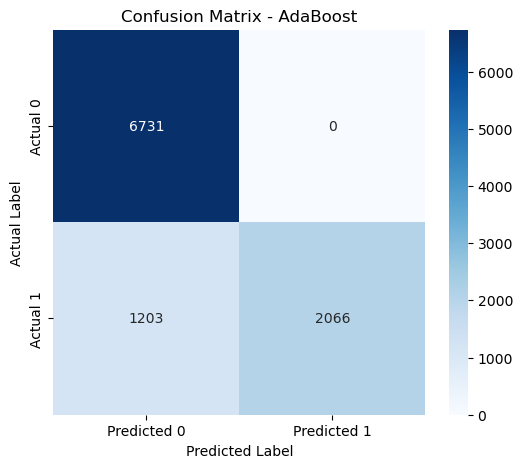

GradientBoosting
CPU times: total: 17.3 s
Wall time: 20.9 s
Accuracy score: 0.8796
F1 score: 0.7744


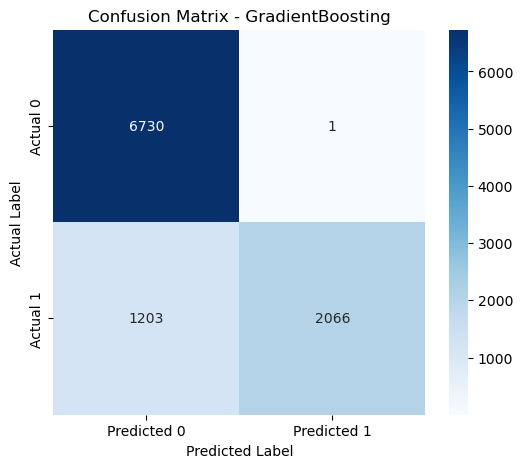

LogisticRegression
CPU times: total: 359 ms
Wall time: 471 ms
Accuracy score: 0.8795
F1 score: 0.7742


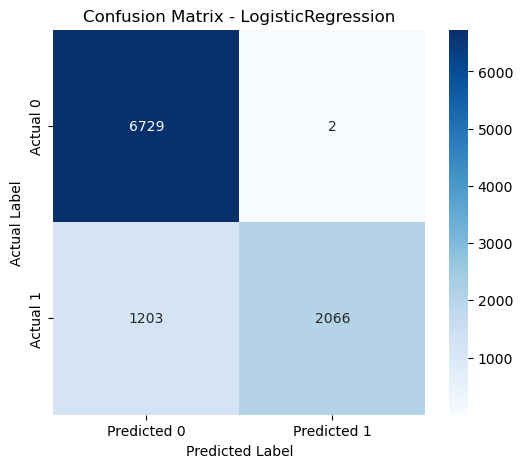

In [27]:
for name, model in models.items():
    print(name)
    %time model.fit(X_train,y_train)
    preds=model.predict(X_test)
    model_evaluation(y_test, preds, name)

In [28]:
joblib.dump(models['LightGBM'], "lightgbm.pkl")

['lightgbm.pkl']